In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('Datathon-1-main/Train.csv')

In [64]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


De antemano se hizo una exploración general de los datos con un pairplot, donde por explocarión 

<AxesSubplot:ylabel='Frequency'>

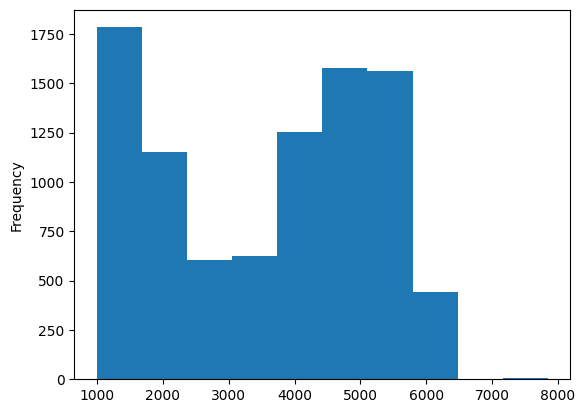

In [11]:

df['Weight_in_gms'].plot.hist()

Se identifica que la mayoria de productos están por debajo de los 7000 mg,por tanto se puede sospechar de que los que están sobre este valor son outliers. Se procede a generar un DataFrame con las modificaciones necesarias, empezando por descartar las 5 entradas cuyo peso está por encima de 7000 mg

In [8]:
df_mod=df.copy()
df_mod=df_mod[(df['Weight_in_gms']<7000)]

df_mod['new_index']=range(0,8994)
df_mod.set_index('new_index',inplace=True)


Se utiliza labelEncoder para las variables categoricas. Esta sirve para pasar las variables categoricas 

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [10]:
#df_mod=df.copy()
cols=['Warehouse_block','Mode_of_Shipment','Product_importance','Gender']
df_mod[cols] = df_mod[cols].apply(LabelEncoder().fit_transform)

In [11]:
df_mod.drop(['ID'],axis=1,inplace=True)


In [7]:
df_mod.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,3,0,4,2,177,3,1,0,44,1233,1
1,4,0,4,5,216,2,1,1,59,3088,1
2,0,0,2,2,183,4,1,1,48,3374,1
3,1,0,3,3,176,4,2,1,10,1177,1
4,2,0,2,2,184,3,2,0,46,2484,1


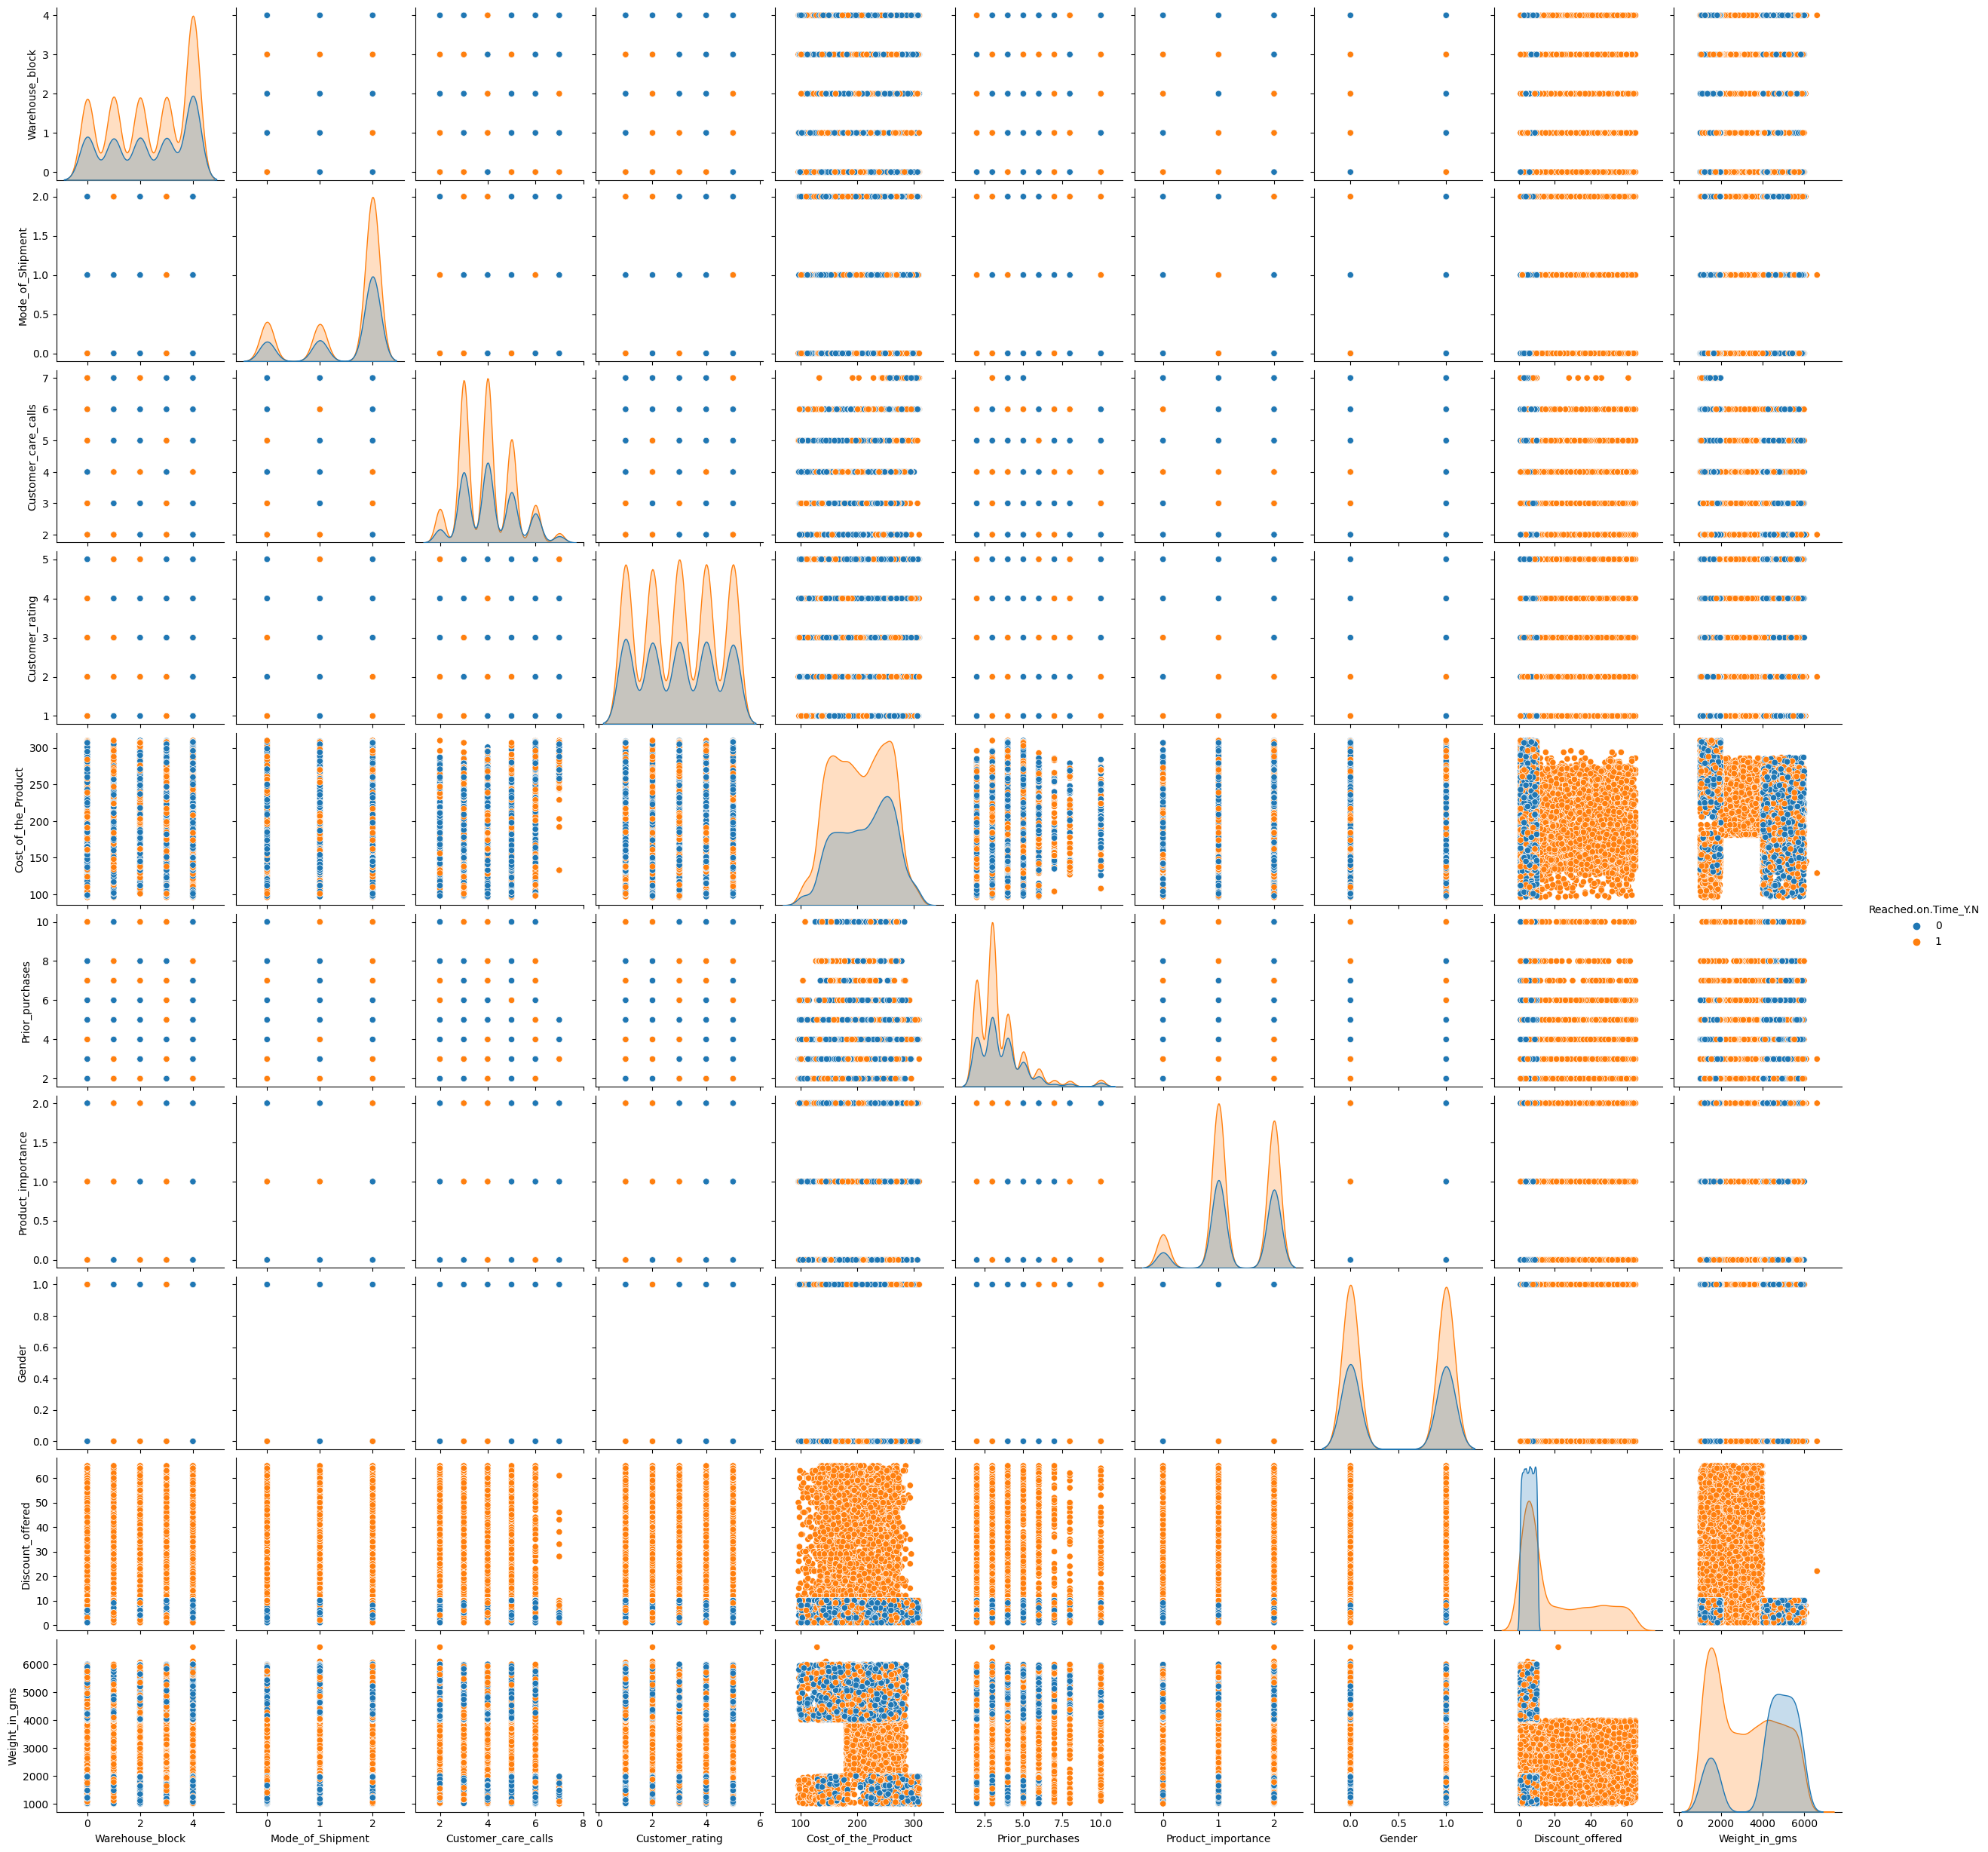

In [63]:
sns.pairplot(df_mod, hue="Reached.on.Time_Y.N")
plt.show()

A partir del pairplot, de primera vista no se ve ninguna que hayan variables relacionadas. 

Se puede destacar que la mayoria de pedidos que llegaron tarde, son los que tenían menor descuento, indicando que este puede ser uno de los parámetros importante para el modelo. Por otra parte los pedidos de mayor peso tienden a llegar fuera de tiempo y viceversa.

In [66]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

Importamos la libreria de StandarScaler para normalizar las variables númericas, de tal forma que la correlación no se vea afectada por valores distantes

In [69]:
cols=['Cost_of_the_Product','Discount_offered','Weight_in_gms']
df_mod[cols] = sc.fit_transform(df_mod[cols])

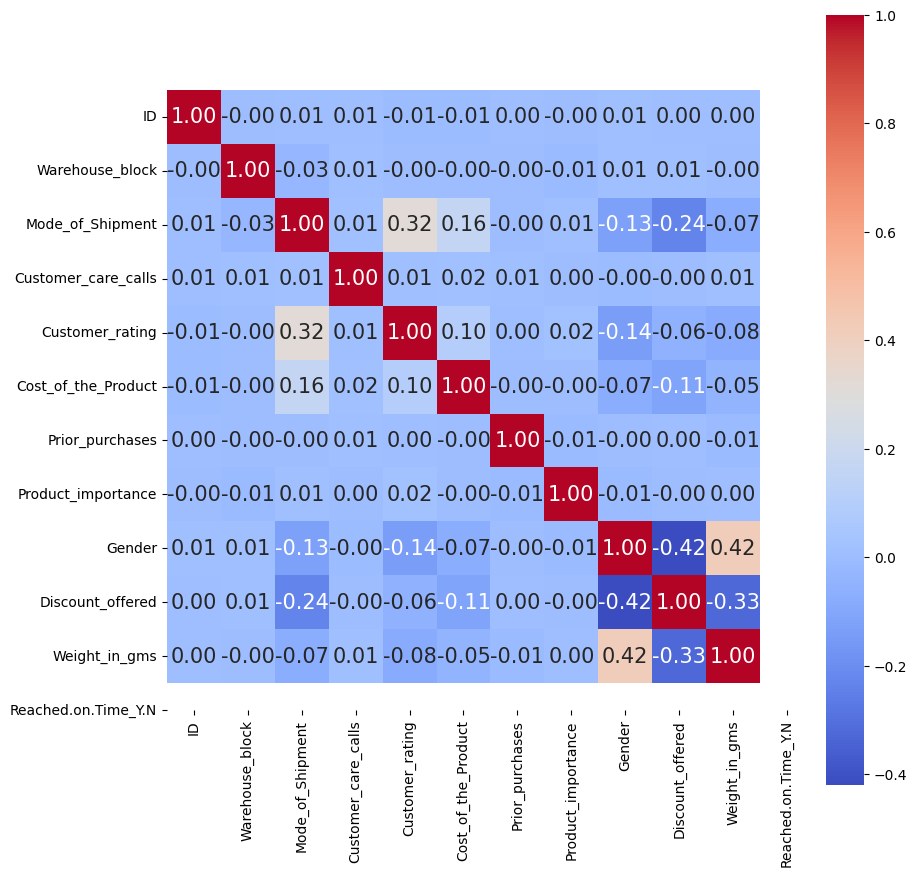

In [75]:
corr = df_mod.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df.columns, 
           yticklabels= df.columns,
           cmap= 'coolwarm')
plt.show()

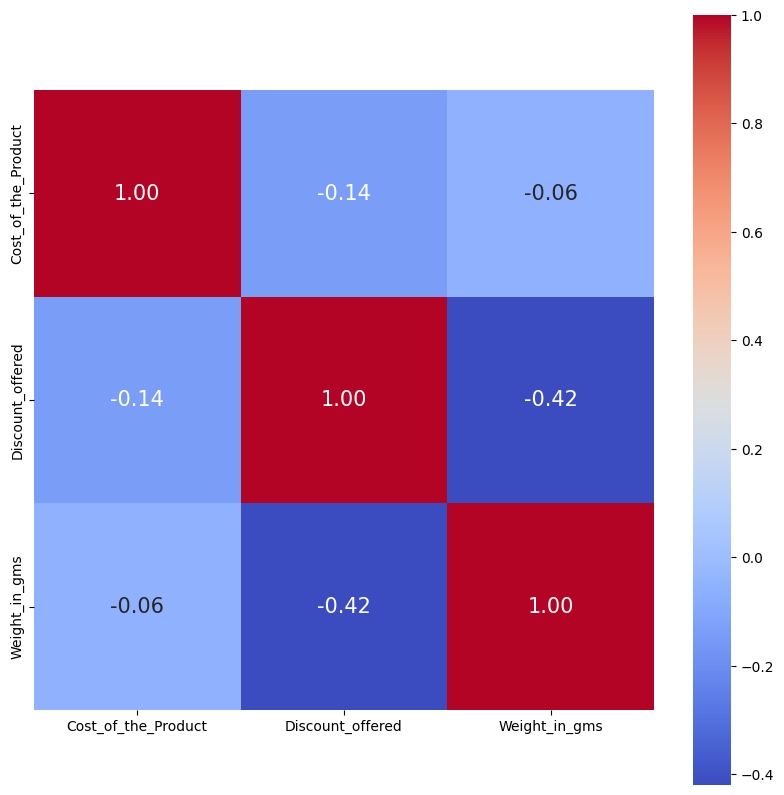

In [73]:
# Realizamos el mapa de calor para ver la correlación entre las variables

corr = df_mod[cols].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= cols, 
           yticklabels= cols,
           cmap= 'coolwarm')
plt.show()

Se sospecha de que 'Gender' no tiene impacto en el modelo y si puede llegar a afectar en un overfitting por lo que se revisa como es su comportamiento con respecto a otras variables

In [107]:
df_mod_0=df_mod[(df_mod['Gender']==0)]['Weight_in_gms']
df_mod_1=df_mod[(df_mod['Gender']==1)]['Weight_in_gms']

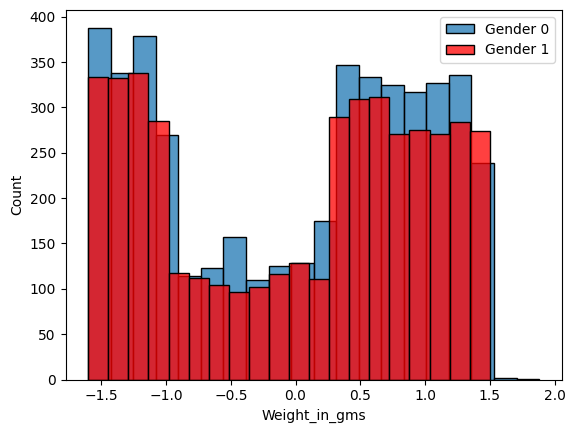

In [108]:
sns.histplot(df_mod_0, bins = 20, label = 'Gender 0')
sns.histplot(df_mod_1, bins = 20, label = 'Gender 1', color = 'r')
plt.legend()

### ***Entrenamiento ML***

In [12]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8994 entries, 0 to 8993
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Warehouse_block      8994 non-null   int32
 1   Mode_of_Shipment     8994 non-null   int32
 2   Customer_care_calls  8994 non-null   int64
 3   Customer_rating      8994 non-null   int64
 4   Cost_of_the_Product  8994 non-null   int64
 5   Prior_purchases      8994 non-null   int64
 6   Product_importance   8994 non-null   int32
 7   Gender               8994 non-null   int32
 8   Discount_offered     8994 non-null   int64
 9   Weight_in_gms        8994 non-null   int64
 10  Reached.on.Time_Y.N  8994 non-null   int64
dtypes: int32(4), int64(7)
memory usage: 702.7 KB


In [33]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [69]:
# Elegimos variables de entrenamiento (empezamos con tres) y separamos las etiquetas

columnas_entrenamiento = ['Weight_in_gms','Cost_of_the_Product']
X = df_mod[columnas_entrenamiento]
y = df_mod['Reached.on.Time_Y.N']

In [70]:
df_mod['Reached.on.Time_Y.N'].value_counts()

1    5714
0    3280
Name: Reached.on.Time_Y.N, dtype: int64

In [71]:
# Generamos un modelo que diga siempre va a llegar a tiempo y medimos su presición
y_pred = np.ones(y.shape)
accuracy_ceros = metrics.accuracy_score(y,y_pred)
print(accuracy_ceros)

0.6353124305092284


In [32]:
# Generamos un modelo que diga siempre va a llegar a tiempo y medimos su sensibilidad
y_pred = np.ones(y.shape)

precision = metrics.recall_score(y, y_pred)
print(precision)

1.0


In [72]:
# Separamos nuestros datos

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

In [73]:
clf = LogisticRegression()
clf.fit(X_train,y_train)

LogisticRegression()

In [74]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [75]:
precision_train = metrics.recall_score(y_train, y_pred_train)
precision_test = metrics.recall_score(y_test, y_pred_test)

print(precision_train)
print(precision_test)

0.8602150537634409
0.8577259475218659


In [76]:
# Se define el clasificador
svm = SVC(gamma=2, C=1)

# Se entrena el modelo
svm.fit(X_train, y_train)

# Predicciones
y_train_pred_svc = svm.predict(X_train)
y_test_pred_svc = svm.predict(X_test)

In [77]:
precision_train = metrics.recall_score(y_train, y_train_pred_svc)
precision_test = metrics.recall_score(y_test, y_test_pred_svc)

print(precision_train)
print(precision_test)

1.0
0.9959183673469387


### ***Predicción del Test***

In [78]:
df_test=pd.read_csv('Datathon-1-main/Test.csv')
cols=['Warehouse_block','Mode_of_Shipment','Product_importance','Gender']
df_test[cols] = df_test[cols].apply(LabelEncoder().fit_transform)
df.drop(['ID'],axis=1,inplace=True)

df_test_ml=df_test.copy()

In [80]:
# Elegimos variables de entrenamiento (empezamos con tres) y separamos las etiquetas
#columnas_test = ['Weight_in_gms','Cost_of_the_Product']

X_test = df_test[columnas_entrenamiento]

In [87]:
#y_pred = svm.predict(X_test)
y_pred=clf.predict(X_test)
y_out=pd.Series(y_pred)

In [88]:
y_out.value_counts()

1    1422
0     578
dtype: int64